In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.decomposition import PCA
# from sklearn.feature_selection import forward_selection

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from mord import LogisticIT

import seaborn as sns
from dmba import classificationSummary, gainsChart, liftChart
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score


import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Import dataset
df = pd.DataFrame(pd.read_csv("masked.csv"))
num_rows, num_cols = df.shape

In [3]:
# Inspect dataset
df.head()

# Drop empty column 'renewal_date'
df = df.drop(columns='renewal_date')


In [4]:
# Create list of numerical and categorical variables
numerical = list(df.select_dtypes('number').columns)
categorical = list(df.select_dtypes('object', 'category').columns)

print(categorical)

['customer_id', 'service_rep', 'primary_user_type', 'section_name', 'row', 'price_code', 'arena_level', 'education_level', 'season']


In [5]:
# Gather descriptive statistics
df.describe()

,zip_code,tenure,last_season_utilization,current_season_utilization,number_of_seats,seat_start,seat_finish,aisle_seat,current_price_per_seat,next_season_price_per_seat,...,email_click_thru_rate,events_attendance,survey_participation,share_partner,pay_in_full,auto_renew,merch_spend,concessions_spend,total_rep_touchpoints,renewed_next_season
count,7628.000000,7628.000000,7628.000000,7628.000000,7628.000000,7628.000000,7628.000000,7628.000000,7628.000000,7628.000000,...,7628.000000,7628.000000,7628.000000,7628.000000,7628.000000,7628.000000,7628.000000,7628.000000,7628.000000,7628.000000
mean,30921.238332,5.521238,0.649782,0.649681,3.007997,99.710540,101.718537,0.500131,223.942440,235.132880,...,0.247589,4.459098,1.987546,0.491741,0.500262,0.488332,247.563407,506.859061,9.355139,0.631751
std,31554.545743,2.851593,0.202448,0.203169,1.416738,57.109469,57.140011,0.500033,100.673049,105.997058,...,0.196308,2.865277,1.414020,0.499965,0.500033,0.499897,144.478101,288.125018,5.763020,0.482361
min,10001.000000,1.000000,0.300035,0.300198,1.000000,1.000000,1.000000,0.000000,50.000000,50.181841,...,0.000019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000
25%,10002.000000,3.000000,0.472823,0.471543,2.000000,50.000000,52.000000,0.000000,137.360000,143.711759,...,0.088681,2.000000,1.000000,0.000000,0.000000,0.000000,122.312500,257.477500,4.000000,0.000000
50%,10003.000000,6.000000,0.650948,0.651881,3.000000,99.000000,102.000000,1.000000,223.945000,235.048675,...,0.196275,4.000000,2.000000,0.000000,1.000000,0.000000,244.785000,508.655000,9.000000,1.000000
75%,30301.000000,8.000000,0.823799,0.826233,4.000000,149.000000,151.000000,1.000000,312.175000,326.565174,...,0.367586,7.000000,3.000000,1.000000,1.000000,1.000000,373.492500,756.115000,14.000000,1.000000
max,90210.000000,10.000000,0.999992,0.999918,5.000000,199.000000,203.000000,1.000000,399.890000,438.837073,...,0.890925,9.000000,4.000000,1.000000,1.000000,1.000000,499.940000,999.870000,19.000000,1.000000


In [6]:
# sanity check
df.head()

,customer_id,zip_code,service_rep,tenure,primary_user_type,last_season_utilization,current_season_utilization,number_of_seats,seat_start,seat_finish,...,events_attendance,survey_participation,share_partner,pay_in_full,auto_renew,merch_spend,concessions_spend,total_rep_touchpoints,season,renewed_next_season
0,202122_CUST00000,10002,Alice,1,personal,0.547598,0.448944,4,37,40,...,6,0,1,0,1,465.30,886.76,19,2021-22,1
1,202122_CUST00001,90210,Danielle,8,personal,0.992576,0.774989,1,166,166,...,0,1,0,0,1,262.18,223.01,5,2021-22,1
2,202122_CUST00002,90210,Carlos,5,business,0.394749,0.389658,4,116,119,...,4,1,1,0,1,98.80,42.49,0,2021-22,1
3,202122_CUST00003,10002,Bob,9,business,0.554721,0.808274,1,41,41,...,6,1,1,0,0,482.57,777.45,3,2021-22,1
4,202122_CUST00004,90210,Carlos,8,personal,0.858839,0.806190,3,117,119,...,2,2,0,1,1,472.30,344.32,1,2021-22,1


In [7]:
# Separate One Hot list from label encoder list
one_list = ['service_rep', 'row', 'arena_level',  'section_name']
label_list = list((set(categorical) - set(one_list) - {'customer_id'}) | {'zip_code'}|{'education_level'})
# del label_list[4]
label_list

['education_level', 'season', 'price_code', 'zip_code', 'primary_user_type']

In [8]:
# One hot encoded 
df_hotencoded = pd.get_dummies(df, columns=one_list, dtype=int)
#df_hotencoded['education_level']


In [9]:
# Label encoding, resulting in an encoded dataset
from sklearn.preprocessing import LabelEncoder


df_encoded = df_hotencoded.copy()
df_encoded[label_list] = df_hotencoded[label_list].apply(LabelEncoder().fit_transform)
df_encoded[label_list]

,education_level,season,price_code,zip_code,primary_user_type
0,0,0,3,1,2
1,0,0,0,4,2
2,2,0,0,4,1
3,1,0,3,1,1
4,2,0,0,4,2
...,...,...,...,...,...
7623,2,3,2,2,2
7624,2,3,3,1,2
7625,2,3,0,1,2
7626,1,3,0,2,2


In [10]:
# Sanity Check
df_encoded.columns

Index(['customer_id', 'zip_code', 'tenure', 'primary_user_type',
       'last_season_utilization', 'current_season_utilization',
       'number_of_seats', 'seat_start', 'seat_finish', 'price_code',
       'aisle_seat', 'current_price_per_seat', 'next_season_price_per_seat',
       'current_season_personal_attendance', 'age', 'education_level',
       'children', 'games_posted_for_resale', 'games_resold',
       'games_forwarded', 'email_open_rate', 'email_click_thru_rate',
       'events_attendance', 'survey_participation', 'share_partner',
       'pay_in_full', 'auto_renew', 'merch_spend', 'concessions_spend',
       'total_rep_touchpoints', 'season', 'renewed_next_season',
       'service_rep_Alice', 'service_rep_Bob', 'service_rep_Carlos',
       'service_rep_Danielle', 'row_A', 'row_B', 'row_C', 'row_D', 'row_E',
       'row_F', 'row_G', 'row_H', 'row_I', 'row_J', 'row_K', 'row_L', 'row_M',
       'arena_level_club', 'arena_level_floor', 'arena_level_lower bowl',
       'arena_leve

In [11]:
# Split data set based on season. ID starting with "202425_CUST***" 

# Rows where 'ID' starts with '202425'
test_data = df_encoded[df_encoded['customer_id'].str.startswith('202425')]



# Rows where 'ID' does NOT start with '202425'
train_data = df_encoded[~df_encoded['customer_id'].str.startswith('202425')]


#test_data.shape
print([train_data.shape, test_data.shape])
print(test_data.shape[0] + train_data.shape[0])
print(str(((5760 / 7628) * 100)) + '%' + ' train split')

[(5760, 59), (1868, 59)]
7628
75.51127425275301% train split


In [12]:
df.tail()

,customer_id,zip_code,service_rep,tenure,primary_user_type,last_season_utilization,current_season_utilization,number_of_seats,seat_start,seat_finish,...,events_attendance,survey_participation,share_partner,pay_in_full,auto_renew,merch_spend,concessions_spend,total_rep_touchpoints,season,renewed_next_season
7623,202425_CUST02993,10003,Danielle,3,personal,0.687694,0.873136,4,29,32,...,3,3,1,0,0,63.70,735.52,13,2024-25,0
7624,202425_CUST02994,10002,Danielle,2,personal,0.632342,0.517969,2,104,105,...,2,3,1,0,1,354.79,7.13,7,2024-25,0
7625,202425_CUST02995,10002,Alice,4,personal,0.359477,0.341301,1,176,176,...,3,1,0,1,1,224.08,870.29,1,2024-25,0
7626,202425_CUST02996,10003,Bob,7,personal,0.866737,0.493909,2,91,92,...,9,4,1,1,0,177.45,474.61,8,2024-25,0
7627,202425_CUST02999,10001,Bob,5,personal,0.339936,0.728909,2,81,82,...,8,0,0,1,0,352.32,601.89,12,2024-25,0


In [13]:
# Resizing Train, val, and test sets. Approx 50/25/25 split. 
## This is due to the 2024/2025 season being the test set exclusively, yet it accounts for 24.5% of the dataset
### Because this is more demonstrative, this split will be accepted. More ideal would be closer to 80/10/10, 70/15/15, etc. 
## Scale Features
# Create the scaler
scaler = StandardScaler()


# Define test start index
test_start = 5760

# Split test set
df_test = df_encoded.iloc[test_start:]  # Rows 5760 to 7627 (~1,869 rows)

# Split remaining data into train and val
remaining = df_encoded.iloc[:test_start]  # Rows 0 to 5759 (5,760 rows)

# Calculate train and val sizes (50% and 25% of total 7,628 rows)
train_size = int(0.5 * len(df_encoded))  # 3,814 rows
val_size = int(0.25 * len(df_encoded))   # 1,907 rows

# Split remaining data
df_train = remaining.iloc[:train_size]          # Rows 0 to 3813
df_val = remaining.iloc[train_size:train_size + val_size]  # Rows 3814 to 5720


# Train, Validation, and test splits

## Train
X_train = df_train.drop(columns=['renewed_next_season', 'customer_id'])
X_train_scaled = scaler.fit_transform(X_train)
y_train = df_train['renewed_next_season']

## Validation
X_val = df_val.drop(columns=['renewed_next_season', 'customer_id'])
X_val_scaled = scaler.transform(X_val)
y_val = df_val['renewed_next_season']

## Test
X_test = df_test.drop(columns=['renewed_next_season', 'customer_id'])
y_test = df_test['renewed_next_season']



Logistic Regression Model 

In [14]:
# Transform the test data 
# fit a logistic regression (set penalty=12 and C=1e42 to avoid regularization)
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
print("Model")
print('Intercept', model.intercept_)
print('Coefficients', model.coef_)

print('intercept', model.intercept_[0])

#print(pd.DataFrame({'coeff': model.coef_[0]}, index=X_train_scaled.columns).transpose())

#print('AIC', AIC_score(y_val, model.predict(X_val), df = len(X_train.columns) + 1))

Model
Intercept [1.58407335]
Coefficients [[ 0.01836139 -0.02352407  0.02985436 -0.05990461 -0.01335024 -0.01340229
  -0.02441423 -0.02473182  0.01812935  0.05611362 -0.02981096 -0.01816679
  -0.01666768 -0.01532231  0.03733967  0.02072677  0.02641633 -0.0222852
  -0.0065103  -0.03728972  0.02491279  0.02027644 -0.03494125 -0.07884143
   0.02419469 -0.00485866 -0.02659664  0.04333376 -0.00890066  0.00136626
   0.04875867 -0.00197469 -0.05604159  0.00845324 -0.03598875  0.01218591
   0.03149254  0.04424366  0.01572844 -0.04590063 -0.00351185 -0.04360068
  -0.00811771  0.00970192  0.00835071 -0.01681239  0.03492924  0.01920743
   0.03178065 -0.01485267 -0.03526186 -0.05051723  0.04611293 -0.01642948
   0.05090923 -0.02163474 -0.0095676 ]]
intercept 1.58407334963539


In [15]:
from sklearn.linear_model import LogisticRegression

# Initialize the model (you can tune hyperparameters as needed)
model = LogisticRegression(max_iter=1000)

# Fit the model on the training data
model.fit(X_train_scaled, y_train)

# Predict probabilities on the validation set
val_probs = model.predict_proba(X_val_scaled)[:, 1]

# Predict probabilities on the test set
test_probs = model.predict_proba(X_test)[:, 1]

from sklearn.metrics import roc_auc_score, log_loss

# Example: Calculate ROC AUC on validation and test sets
val_auc = roc_auc_score(y_val, val_probs)
test_auc = roc_auc_score(y_test, test_probs)


print(f"Validation probabilities: {val_probs}")
print(f"Validation AUC: {val_auc:.3f}")

print(f"Test probabilities: {test_probs}")



Validation probabilities: [0.81433517 0.76990021 0.80385971 ... 0.8487013  0.79187392 0.83731005]
Validation AUC: 0.498
Test probabilities: [9.99667153e-01 3.33833818e-06 9.00929513e-03 ... 9.97538741e-01
 4.56318277e-04 9.74842149e-01]


In [16]:
# Prediction Values
y_train_pred = model.predict(X_train_scaled)
val_y_pred = model.predict(X_val_scaled)


# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_val, val_y_pred)

# Calculate confusion matrices
train_conf_matrix = confusion_matrix(y_train, y_train_pred)
test_conf_matrix = confusion_matrix(y_val, val_y_pred)

# Calculate classification reports
train_class_report = classification_report(y_train, y_train_pred)
val_class_report = classification_report(y_val, val_y_pred)

# Train Reports
print('Training Accuracy:', train_accuracy)
print('Training Classification Report:\n', train_class_report)
print("\n")

# Test Reports
print('Validation Accuracy:', test_accuracy)
print('Validation Classification Report:\n', val_class_report)


Training Accuracy: 0.826953329837441
Training Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       660
           1       0.83      1.00      0.91      3154

    accuracy                           0.83      3814
   macro avg       0.41      0.50      0.45      3814
weighted avg       0.68      0.83      0.75      3814



Validation Accuracy: 0.853696906135291
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       279
           1       0.85      1.00      0.92      1628

    accuracy                           0.85      1907
   macro avg       0.43      0.50      0.46      1907
weighted avg       0.73      0.85      0.79      1907



In [17]:
allVariables = X_train.columns
allVariables

Index(['zip_code', 'tenure', 'primary_user_type', 'last_season_utilization',
       'current_season_utilization', 'number_of_seats', 'seat_start',
       'seat_finish', 'price_code', 'aisle_seat', 'current_price_per_seat',
       'next_season_price_per_seat', 'current_season_personal_attendance',
       'age', 'education_level', 'children', 'games_posted_for_resale',
       'games_resold', 'games_forwarded', 'email_open_rate',
       'email_click_thru_rate', 'events_attendance', 'survey_participation',
       'share_partner', 'pay_in_full', 'auto_renew', 'merch_spend',
       'concessions_spend', 'total_rep_touchpoints', 'season',
       'service_rep_Alice', 'service_rep_Bob', 'service_rep_Carlos',
       'service_rep_Danielle', 'row_A', 'row_B', 'row_C', 'row_D', 'row_E',
       'row_F', 'row_G', 'row_H', 'row_I', 'row_J', 'row_K', 'row_L', 'row_M',
       'arena_level_club', 'arena_level_floor', 'arena_level_lower bowl',
       'arena_level_upper bowl', 'section_name_101', 'section_n

LOGISTIC REGRESSION FEATURE SELECTION WORK

In [18]:
### Principal Component Analysis
from sklearn.decomposition import PCA

## Consider 4 components 
PCA = PCA(n_components=4)
x = PCA.fit_transform(X_train_scaled)


## create dataframe
pca4_df = pd.DataFrame(data=x, columns=['PC1', 'PC2', 'PC3', 'PC4'])
pca4_df

# Check dimensions of data after PCA 
print(f"Principal Component Matrix Dimensions: {x.shape}")
print("")
print("Principal Component Matrix")
print(pca4_df)

Principal Component Matrix Dimensions: (3814, 4)

Principal Component Matrix
           PC1       PC2       PC3       PC4
0    -1.770997 -0.359557  0.828663 -0.770974
1     1.443200 -1.137115 -0.184181  0.141915
2    -0.066424 -1.674814 -1.341858 -0.115151
3    -0.989880  2.076800  0.459889  1.505630
4    -0.002168 -0.487046  2.624321 -0.395319
...        ...       ...       ...       ...
3809 -0.204551 -1.249891  1.754447 -0.332545
3810 -2.013731 -0.595367  1.054844 -0.316079
3811 -1.966943  0.977395  1.949956  0.338412
3812  0.164372  1.763886  0.781515  1.001231
3813 -0.569901  2.041793  1.902246  0.195627

[3814 rows x 4 columns]


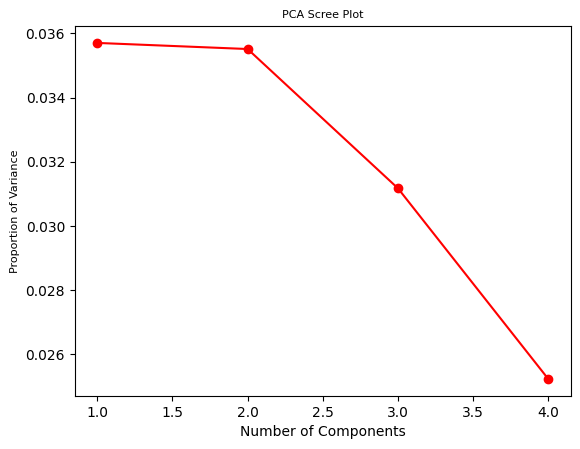

In [19]:
# Component Analysis
# Use Elbow Rule 
prop_var = PCA.explained_variance_ratio_
eigenvalues = PCA.explained_variance_

PC_numbers = np.arange(PCA.n_components_) + 1

plt.plot(PC_numbers, prop_var, 'ro-')
plt.title('PCA Scree Plot', fontsize=8)
plt.xlabel('Number of Components')
plt.ylabel('Proportion of Variance', fontsize=8)
plt.show()

# Based on Elbow Rule, keep 2 components 

[[-9.00337548e-03 -1.43696406e-02 -5.08630958e-02 -1.00221104e-01]
 [-1.52884876e-02 -5.68852957e-02  1.24347193e-02  4.21376836e-02]
 [-3.11219044e-02  5.70683077e-03 -4.89233888e-02 -6.88396256e-02]
 [ 3.83724900e-02 -1.92678896e-02  2.42002754e-02  1.04443187e-02]
 [ 1.59963446e-02 -2.54474242e-02 -5.03816586e-02 -1.59721320e-01]
 [ 3.90003854e-02 -2.08863972e-02  3.43955214e-02 -4.42376127e-02]
 [ 9.53415298e-01 -2.26153439e-01  1.51677035e-01  2.54858244e-02]
 [ 9.53847149e-01 -2.26543428e-01  1.52442440e-01  2.43783317e-02]
 [-7.14561651e-02 -1.51256995e-02  1.08877260e-03  3.29109270e-03]
 [-6.91792500e-03 -1.13481813e-02  2.22472527e-02 -2.61707664e-02]
 [ 2.34658216e-01  9.62119921e-01 -4.16578511e-02  5.10807029e-03]
 [ 2.34483019e-01  9.62340216e-01 -4.13352751e-02  4.67732396e-03]
 [-6.48294133e-02 -1.07595881e-02  3.08030744e-02 -1.20516044e-02]
 [-4.46479679e-02  1.66365447e-03 -1.27614634e-03  6.14928473e-02]
 [-3.15273685e-02  7.89215429e-03  2.36718533e-02  1.25976434e

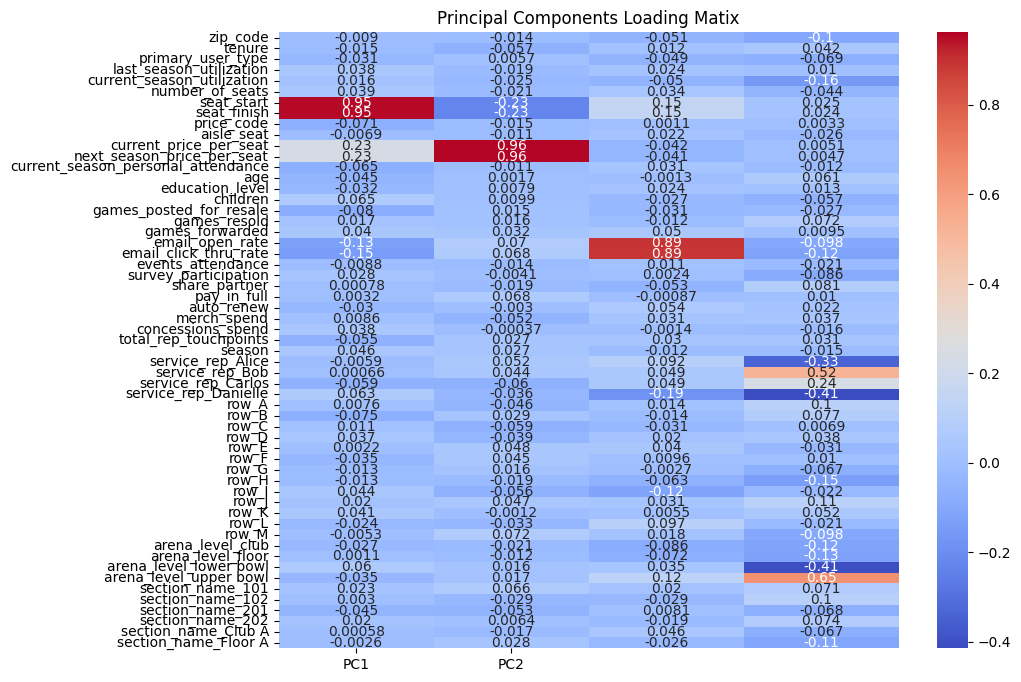

In [20]:
# Extract loadings
loadings = PCA.components_.T * np.sqrt(PCA.explained_variance_)
print(loadings)

# Plot heatmap of loadings
plt.figure(figsize=(10, 8))
sns.heatmap(loadings, annot=True, cmap='coolwarm', yticklabels=X_train.columns, xticklabels=['PC1', 'PC2'])
plt.title('Principal Components Loading Matix')
plt.show()

In [21]:
# PCA variance analysis
print(f"The eigenvalue of PC1 is: {PCA.explained_variance_[0]}")
print(f"The eigenvalue of PC2 is: {PCA.explained_variance_[1]}")
print(f"Explained variability per component: {PCA.explained_variance_ratio_}")



The eigenvalue of PC1 is: 2.035503142304651
The eigenvalue of PC2 is: 2.0246660269751953
Explained variability per component: [0.03570122 0.03551114 0.03117213 0.02523206]


In [22]:
# Top features
top_feat = ['seat_start', 'seat_finish', 'current_price_per_seat', 'next_season_price_per_seat', 'email_open_rate', 'email_click_thru_rate', 'service_rep_Bob']# 'arena_level_upper_bowl']

# Train, Validation, and test splits

## Train
X_train_top = df_train[top_feat]
X_train_top_scaled = scaler.fit_transform(X_train_top)
y_train_top = df_train['renewed_next_season']

## Validation
X_val_top = df_val[top_feat]
X_val_top_scaled = scaler.transform(X_val_top)
y_val_top = df_val['renewed_next_season']

## Test
X_test_top = df_test[top_feat]
y_test_top = df_test['renewed_next_season']


# Transform the test data 
# fit a logistic regression (set penalty=12 and C=1e42 to avoid regularization)
model_top = LogisticRegression()
model_top.fit(X_train_top_scaled, y_train_top)
print("Model")
print('Intercept', model_top.intercept_)
print('Coefficients', model_top.coef_)

print('intercept', model_top.intercept_[0])

#print(pd.DataFrame({'coeff': model.coef_[0]}, index=X_train_scaled.columns).transpose())

#print('AIC', AIC_score(y_val, model.predict(X_val), df = len(X_train.columns) + 1))


Model
Intercept [1.56617627]
Coefficients [[ 0.02026775 -0.07016732 -0.1771098   0.13444385 -0.03254319  0.01853216
  -0.00735282]]
intercept 1.566176271477218


In [23]:
from sklearn.linear_model import LogisticRegression

# Initialize the model (you can tune hyperparameters as needed)
model_top = LogisticRegression(max_iter=1000)

# Fit the model on the training data
model_top.fit(X_train_top_scaled, y_train_top)

# Predict probabilities on the validation set
val_probs_top_0 = model_top.predict_proba(X_val_top_scaled)[:, 0]
val_probs_top_1 = model_top.predict_proba(X_val_top_scaled)[:, 1]


# Predict probabilities on the test set
test_probs_top_0 = model_top.predict_proba(X_test_top)[:, 0]
test_probs_top_1 = model_top.predict_proba(X_test_top)[:, 1]

from sklearn.metrics import roc_auc_score, log_loss

# Example: Calculate ROC AUC on validation and test sets
val_auc_top_0 = roc_auc_score(y_val_top, val_probs_top_0)
val_auc_top_1 = roc_auc_score(y_val_top, val_probs_top_1)
test_auc_top_0 = roc_auc_score(y_test_top, test_probs_top_0)
test_auc_top_1 = roc_auc_score(y_test_top, test_probs_top_1)

print(f"Validation probabilities for 0: {val_probs_top_0}")
print(f"Validation probabilities for 1: {val_probs_top_1}\n")

print(f"Validation AUC 0: {val_auc_top_0:.3f}")
print(f"Validation AUC 1: {val_auc_top_1:.3f}\n")

print(f"Test probabilities 0: {test_probs_top_0}")
print(f"Test probabilities 1: {test_probs_top_1}\n")


Validation probabilities for 0: [0.1798847  0.19967752 0.17872385 ... 0.15547967 0.16761348 0.15867189]
Validation probabilities for 1: [0.8201153  0.80032248 0.82127615 ... 0.84452033 0.83238652 0.84132811]

Validation AUC 0: 0.475
Validation AUC 1: 0.525

Test probabilities 0: [0.99622825 1.         0.99989879 ... 1.         0.99999979 0.99995315]
Test probabilities 1: [3.77175055e-03 9.63417430e-10 1.01210741e-04 ... 6.83360137e-10
 2.13514002e-07 4.68504545e-05]



In [24]:
# Prediction Values
y_train_pred_top = model_top.predict(X_train_top_scaled)
val_y_pred_top = model_top.predict(X_val_top_scaled)


# Calculate accuracy
train_top_accuracy = accuracy_score(y_train_top, y_train_pred_top)
test_top_accuracy = accuracy_score(y_val_top, val_y_pred_top)

# Calculate confusion matrices
train_conf_top_matrix = confusion_matrix(y_train_top, y_train_pred_top)
test_conf_top_matrix = confusion_matrix(y_val_top, val_y_pred_top)

# Calculate classification reports
train_class_top_report = classification_report(y_train_top, y_train_pred_top)
val_class_top_report = classification_report(y_val_top, val_y_pred_top)

# Train Reports
print('Training Accuracy:', train_top_accuracy)
print('Training Classification Report:\n', train_class_top_report)
print("\n")

# Test Reports
print('Validation Accuracy:', test_top_accuracy)
print('Validation Classification Report:\n', val_class_top_report)

Training Accuracy: 0.826953329837441
Training Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       660
           1       0.83      1.00      0.91      3154

    accuracy                           0.83      3814
   macro avg       0.41      0.50      0.45      3814
weighted avg       0.68      0.83      0.75      3814



Validation Accuracy: 0.853696906135291
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       279
           1       0.85      1.00      0.92      1628

    accuracy                           0.85      1907
   macro avg       0.43      0.50      0.46      1907
weighted avg       0.73      0.85      0.79      1907



Random Forest Algorithm

In [79]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

# Initialize RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_classifier.predict(X_val)

# Calculate accuracy and classification report
accuracy = accuracy_score(y_val, y_pred_rf)
classification_rep_rf = classification_report(y_val, y_pred_rf)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep_rf)

# Probabilities
probabilities_rf = rf_classifier.predict_proba(X_test)
print("Class probabilities: ", (probabilities_rf))

# Sample prediction
n = np.random.randint(0, len(df))
sample = X_test.iloc[0:n]  # Keep as DataFrame to match model input format
sample_prediction_rf = rf_classifier.predict(sample)
sample_prediction_rfProba = rf_classifier.predict_proba(sample)

# Retrieve and display the sample
sample_dict_rf = sample.iloc[0].to_dict()
print(f"\nSample Season Ticket Holder: {sample_dict_rf}")
print(f"Predicted Renewal: {'Renewed (1)' if sample_prediction_rf[0] == 1 else 'Did Not Renew (0)'}")




Accuracy: 0.63

Classification Report:
               precision    recall  f1-score   support

           0       0.18      0.42      0.25       279
           1       0.87      0.66      0.75      1628

    accuracy                           0.63      1907
   macro avg       0.52      0.54      0.50      1907
weighted avg       0.77      0.63      0.68      1907

Class probabilities:  [[0.45 0.55]
 [0.46 0.54]
 [0.46 0.54]
 ...
 [0.42 0.58]
 [0.49 0.51]
 [0.46 0.54]]

Sample Season Ticket Holder: {'zip_code': 0.0, 'tenure': 5.0, 'primary_user_type': 2.0, 'last_season_utilization': 0.773870007347593, 'current_season_utilization': 0.9613649268957892, 'number_of_seats': 5.0, 'seat_start': 90.0, 'seat_finish': 94.0, 'price_code': 1.0, 'aisle_seat': 0.0, 'current_price_per_seat': 66.44, 'next_season_price_per_seat': 70.04668059296569, 'current_season_personal_attendance': 23.0, 'age': 46.0, 'education_level': 1.0, 'children': 1.0, 'games_posted_for_resale': 4.0, 'games_resold': 2.0, 'games

In [82]:
# Get feature importance
grid_importance = pd.DataFrame({
    'Random Forest feature': X_train.columns,
    'Importance': rf_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

print(grid_importance.head(10))

         Random Forest feature  Importance
27           concessions_spend    0.048353
19             email_open_rate    0.047992
26                 merch_spend    0.047883
3      last_season_utilization    0.047157
10      current_price_per_seat    0.046421
4   current_season_utilization    0.046236
20       email_click_thru_rate    0.046143
11  next_season_price_per_seat    0.045926
6                   seat_start    0.044151
7                  seat_finish    0.043845


In [27]:
param_grid = {
    'n_estimators': [25, 50, 100],           # Number of trees in the forest
    'max_depth': [None, 5, 10],              # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],          # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],            # Minimum samples required at each leaf node
    'max_features': ['sqrt', 'log2', None]    # Number of features to consider at each split
}


In [ ]:
mod = RandomForestClassifier()
grid_search = GridSearchCV(mod,
                           param_grid=param_grid,
                           cv = 5,
                           scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

grid_bestmodel = grid_search.best_estimator_
grid_valscore = grid_bestmodel.score(X_val, y_val)

print("Best Model: ", grid_bestmodel)
print("Validation Score: ", grid_valscore)






Best Model:  RandomForestClassifier(min_samples_leaf=2, min_samples_split=10,
                       n_estimators=25)
Validation Score:  0.8327215521761929


In [ ]:

model_grid = RandomForestClassifier(min_samples_leaf=2,
                                    min_samples_split=10,
                                    max_features=None,
                                    n_estimators=25)
model_grid.fit(X_train_scaled, y_train)
y_pred_grid = model_grid.predict(X_val)

# Accuracy and classifiaction report 
grid_accuracy = accuracy_score(y_val, y_pred_grid)
print(f"Accuracy: {grid_accuracy:.2f}")
print("Classification report for model_grid")
print(classification_report(y_pred_grid, y_val))

# Get feature importance
grid_importance = pd.DataFrame({
    'Grid Search feature': X_train.columns,
    'Importance': model_grid.feature_importances_
}).sort_values('Importance', ascending=False)

print(grid_importance.head(10))


26                 merch_spend    0.117961
3      last_season_utilization    0.082727
27           concessions_spend    0.065853
20       email_click_thru_rate    0.059575
19             email_open_rate    0.058101

Accuracy: 0.81
Classification report for model_grid
              precision    recall  f1-score   support

           0       0.06      0.13      0.08       122
           1       0.93      0.85      0.89      1785

    accuracy                           0.81      1907
   macro avg       0.50      0.49      0.49      1907
weighted avg       0.88      0.81      0.84      1907

           Grid Search feature  Importance
3      last_season_utilization    0.070513
19             email_open_rate    0.063228
27           concessions_spend    0.061509
4   current_season_utilization    0.061105
26                 merch_spend    0.058373
20       email_click_thru_rate    0.056508
13                         age    0.044714
16     games_posted_for_resale    0.042258
18             games_forwarded    0.040550
11  next_season_price_per_seat    0.040272


In [ ]:
# RandomCV Model Optimization 
random_search = RandomizedSearchCV(mod,
                                   param_grid)
random_search.fit(X_train_scaled, y_train)
print(random_search.best_estimator_)

random_bestmodel = random_search.best_estimator_
random_valscore = random_bestmodel.score(X_val, y_val)

print("Best Model: ", random_bestmodel)
print("Validation Score: ", random_valscore)



RandomForestClassifier(max_depth=5, max_features=None, min_samples_split=5,
                       n_estimators=50)
Best Model:  RandomForestClassifier(max_depth=5, max_features=None, min_samples_split=5,
                       n_estimators=50)
Validation Score:  0.853696906135291


In [94]:
# Random Forest with best Randomized Search CV model previously identified
model_random = RandomForestClassifier(max_depth=5,
                                      max_features=None,
                                      min_samples_split=5,
                                      n_estimators=50)
model_random.fit(X_train_scaled, y_train)
y_pred_rand = model_random.predict(X_val)

# Accuracy and classifiaction report 
random_accuracy = accuracy_score(y_val, y_pred_rand)
print(f"Accuracy: {random_accuracy:.2f}")
print("Classification report for random grid")
print(classification_report(y_pred_rand, y_val))

# Get feature importance
random_importance = pd.DataFrame({
    'Random CV feature': X_train.columns,
    'Importance': model_random.feature_importances_
}).sort_values('Importance', ascending=False)

print(random_importance.head(10))


Accuracy: 0.84
Classification report for random grid
              precision    recall  f1-score   support

           0       0.04      0.21      0.07        52
           1       0.97      0.86      0.91      1855

    accuracy                           0.84      1907
   macro avg       0.51      0.53      0.49      1907
weighted avg       0.95      0.84      0.89      1907

             Random CV feature  Importance
26                 merch_spend    0.117961
3      last_season_utilization    0.082727
27           concessions_spend    0.065853
20       email_click_thru_rate    0.059575
19             email_open_rate    0.058101
4   current_season_utilization    0.051674
16     games_posted_for_resale    0.049501
10      current_price_per_seat    0.049422
11  next_season_price_per_seat    0.048429
7                  seat_finish    0.046560
